# Binary Classification Via Logistic Regression in Scikit Learn

## Report Summary

The optimal logistic regression classifier (implemented via sklearn) had a 3-fold cross validated AUROC test score of 0.72 +/- 0.01 and log-loss score of 0.63 +/- 0. When the classifier was applied to an unseen test dataset, the results generalized well since it had an AUROC score of 0.72 and log-loss score of 0.61.

Furthermore, the classifier had a prediction bias of 0.27, i.e. the predicted class labels are on average higher than the actual class labels by 0.27, precision of 2% and recall of 60%. The extremely low precision is extremely concerning and it is possible that there is a severe logical flaw in how this model was trained.

I chose logistic regression for this task since it is a straightforward algorithm particularly well suited for modeling class probabilities.

As expected, the class labels are largely skewed towards non-installations. There are approximately a 100 times more instances of non-installations compared to installations. In order to balance the dataset, I used undersampling. The categorical features were transformed via one hot encoding which led to a very sparse matrix. However, an ad hoc comparison showed that the performance is better when using both the numerical and the categorical features. The numerical features were transformed using the MaxAbsScaler in the sklearn package since some sort of normalization schema is required for logistic regression classifiers to work well. 

Due to the size of the dataset, I used n1-standard-8 (8 vCPUs, 30 GB memory) & 1 NVIDIA Tesla P4 GPU via Google Compute Engine for the task. Despite all the increases in vCPUs and memory, the amount of time taken to perform the cross-validated grid search was taking unreasonably long. In order to get around this issue, I sampled the training dataset and used 400,000 rows of data for the cross-validated grid search. This approach was well justified by the plateaued learning curve, i.e. adding more data beyond 400,000 rows only led to marginal improvements in log-loss score.

Once the optimal parameter of inverse regularization (C) of 0.1 and the L1 norm penalty was determined, the logistic regression classifier was then trained on a subsample of the full training dataset comprised of 800,000 rows that then went through indersampling to balance the classes (Note: There were memory errors when I tried 1.6 million rows). Lastly, once the classifer was trained it was then used to predict the installation probabilities of the test set.

## Future Work

The greatest challenge of this task (for me personally) was to fully utilize the dataset given to train the classifiers. Hence, future work would necessarily involve finding ways to getting around the persistent memory errors. 

Additional sources of performance improvement would include:
1. Experimentation to find an optimal numerical feature normalization scheme.
2. Comparisons of the standard over/undersampling and SMOTE to find a more effective way to cure the class imbalance.

In terms of improving the classifiers, it would be interesting to try:
1. Stochastic Gradient Descent classifiers which might be better suited to this dataset due to its online training abilities.  
2. Deep learning to improve upon the Logistic Regression classifier. 

One of the questions that I would pursue if I had more time is whether the precision and recall remain the same when training the model on larger and larger datasets. While log-loss and AUROC were stable, I'm not sure if that generalizes to the other metrics. And if in fact, the precision and recall learning curves are less stable for smaller datasets, that would be additional reason to utilize the full dataset when performing the grid search.

The sections below contain all the source code for the EDA and model selection. 

# 1. Exploratory Data Analysis

In [1]:
import csv
import datetime as dt
import garbagecollector as gc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random
import time


from scipy.sparse import csc_matrix, hstack 
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.metrics import accuracy_score, \
                            auc, \
                            confusion_matrix, \
                            log_loss, make_scorer, \
                            roc_auc_score, roc_curve, \
                            precision_recall_curve, \
                            precision_score, \
                            recall_score, \
                            f1_score
from sklearn.model_selection import GridSearchCV, \
                                    learning_curve, \
                                    StratifiedKFold, \
                                    train_test_split

In [3]:
data = []
with open('training_data.csv') as f:
    reader = csv.reader(f, delimiter=';', quoting=csv.QUOTE_NONE)
    for row in reader:
        data.append(row)
col_names = data.pop(0)
# shuffled_indices = list(range(0, 800000))
# random.shuffle(shuffled_indices)
# df = pd.DataFrame([data[idx] for idx in shuffled_indices], columns=col_names)
df = pd.DataFrame(data, columns=col_names)
df.head()

del data
gc.collect()

,id,timestamp,campaignId,platform,softwareVersion,sourceGameId,country,startCount,viewCount,clickCount,installCount,lastStart,startCount1d,startCount7d,connectionType,deviceType,install
0,5c36658fb58fad351175f0b6,2019-01-09T21:20:15.943+00:00,59687f0d896a6b0e5ce6ea15,ios,11.4.1,1373094,US,25,24,0,2,2019-01-08T18:49:48.129+00:00,1,8,cellular,"iPhone8,2",0
1,5c38d5ab1c16172870186b5a,2019-01-11T17:43:07.609+00:00,59687f0d896a6b0e5ce6ea15,ios,12.1,2739989,US,10,9,2,0,2019-01-09T21:20:22.855+00:00,1,4,cellular,"iPhone9,1",0
2,5c38815de8f4e50e256e4f9c,2019-01-11T11:43:25.168+00:00,59687f0d896a6b0e5ce6ea15,ios,12.1.2,1373094,US,27,26,0,0,2019-01-09T10:42:08.446+00:00,1,2,cellular,"iPhone7,1",0
3,5c409ace532d5806d2c6a5e6,2019-01-17T15:10:06.420+00:00,59687f0d896a6b0e5ce6ea15,ios,12.1.2,1217749,US,15,14,2,0,2019-01-16T19:58:11.636+00:00,3,14,wifi,"iPhone7,2",0
4,5c3904b92d798c41e7f3088a,2019-01-11T21:03:53.145+00:00,59687f0d896a6b0e5ce6ea15,ios,12.0.1,1373094,US,20,18,0,0,2019-01-11T21:03:05.103+00:00,13,18,cellular,"iPhone8,1",0


In [4]:
df.shape

(3738937, 17)

The training dataset has over 3.5 million records and 17 features. 

In [5]:
numerical_feat = ['startCount', 'viewCount', 'clickCount', 'installCount', 'install', 'startCount1d', 'startCount7d']
categorical_nominal_feat = ['campaignId', 'sourceGameId', 'country', 'platform', 'softwareVersion', 'connectionType', 'deviceType']
for feat in numerical_feat:
    df[feat] = df[feat].astype('int')
df['install'] = df['install'].astype('int')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3738937 entries, 0 to 3738936
Data columns (total 17 columns):
id                 object
timestamp          object
campaignId         object
platform           object
softwareVersion    object
sourceGameId       object
country            object
startCount         int64
viewCount          int64
clickCount         int64
installCount       int64
lastStart          object
startCount1d       int64
startCount7d       int64
connectionType     object
deviceType         object
install            int64
dtypes: int64(7), object(10)
memory usage: 484.9+ MB


The target variable is denoted by the binary variable _install_. The remaining features can be broken down into the categories:

**Numerical**
1. startCount
2. viewCount
3. clickCount
4. installCount
5. startCount1d
6. startCount7d

**Datetime**
1. timestamp
2. lastStart

**Categorical nominal**
1. id
2. campaignId
3. platform
4. softwareVersion
5. sourceGameId
6. country
7. connectionType
8. deviceType


In [6]:
df['install'].value_counts()

0    3694193
1      44744
Name: install, dtype: int64

We find that the class distribution of the install to no-install status is extremely imbalanced at 1:82. Hence, we have to design appropriate strategies when training and testing the prediction models.

In [7]:
df_num = df[numerical_feat]
df_num.corr()

,startCount,viewCount,clickCount,installCount,install,startCount1d,startCount7d
startCount,1.000000,0.918300,0.407195,0.262856,-0.024475,0.448791,0.789326
viewCount,0.918300,1.000000,0.313912,0.243904,-0.022178,0.380549,0.712796
clickCount,0.407195,0.313912,1.000000,0.169596,-0.002935,0.212569,0.352749
installCount,0.262856,0.243904,0.169596,1.000000,0.024735,0.102783,0.181972
install,-0.024475,-0.022178,-0.002935,0.024735,1.000000,-0.014440,-0.023037
startCount1d,0.448791,0.380549,0.212569,0.102783,-0.014440,1.000000,0.682971
startCount7d,0.789326,0.712796,0.352749,0.181972,-0.023037,0.682971,1.000000


We find that the install status is not linearly correlated with any of the numerical variables. Some of the features such as _startCount_ and _viewCount_ are very strongly correlated as expected. While variables such as _startCount_ and _startCount7d_ are strongly correlated. 

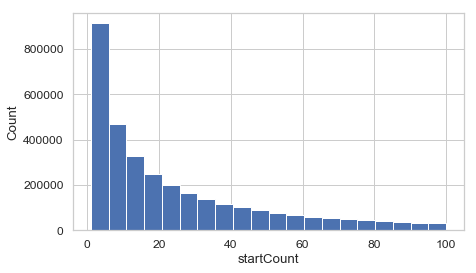

In [8]:
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [7, 4]})
sns.distplot(
    df['startCount'], norm_hist=False, kde=False, bins=20, hist_kws={"range": [1, 100], "alpha": 1}
).set(xlabel='startCount', ylabel='Count');
plt.show()

The distribution of the numerical features are fat-tailed power law distributions. Hence, when it comes to scaling these features, using the standard scaling will be a bad approach. While we only show the startCount in this plot, the other numerical features look very similar.

In [9]:
for feat in categorical_nominal_feat:
    print(feat)
    print("==========")
    print(df[feat].value_counts())
    print("        ")

campaignId
5c3bfb0b36c2c6cc18710e7b    41740
5c385d02ee4549000d8b9ddd    36861
5c0f2ff2f4ee9d00225714c2    32856
5afbea849f23a400284f2619    30286
5c26db700f371292325680ec    28537
5bd2b810eb4bb3b817722baa    27198
5af41f3346d16a019f9d327d    24132
5c333b4d1d94abf8a325e55a    23943
5bd2ccefc9c2110ad461c1b3    23413
5ba35fbb478f4102c28b1811    22811
5bf54928eb052c1002550102    22749
5c12581237b74f001c1fdabb    19606
5b9d371252bb0e3d8ca5c69f    19022
5ba67c1b3f2d330a3d81581e    18984
5c205a1719031b964e854e34    17489
5c18c35e3554c60046a29cf1    16217
5c1cdc81398584f7e2083ac0    16114
5c2713ab56936fad84a91916    16061
5c26e5222127049b4bce982d    15444
5be19ebfea7afe2df87a44cd    15438
5bc44242929dbbd1d615aa1c    14932
5c35a5aa7728298de289b63b    14930
5c1b87728fe2396cc2ab049f    14495
5b6d659b9225dc002ec90dff    14075
5be29c4ba7c03f803c1c6a97    14056
5bd2cccb59f9600aa0e56a51    13738
5ba74a5df85b252db02ef371    12415
5c18c3eade52c203cbea50c2    12022
5c2f3ca39dca190ca96e8471    11889
5c1

This shows us that there are many levels to the data which would add a lot of sparsity and features when transforming the categorical data.


# 2. Logistic Regression Model Tuning


## 2.1 Feature Engineering
### 2.1.1 Use timestamp and lastStart to create timeSinceLastStart feature

In [10]:
def datetime_parser(datetime_str):
    try:
        date_str, time_str = datetime_str.split("T")
    except:
        return 
    time_str=time_str[:8]
    year, month, day = date_str.split("-")
    hour, minut, sec = time_str.split(":")
    return dt.datetime(int(year), int(month), int(day), int(hour), int(minut), int(sec))
        

def time_diff_in_minutes(dt_0, dt_1):
    return np.round((dt_1 - dt_0).total_seconds() / 60.0, 0)

In [ ]:
df.timestamp = df.timestamp.apply(datetime_parser)
df.lastStart = df.lastStart.apply(datetime_parser)

df['timeSinceLastStart'] = df.apply(lambda row: time_diff_in_minutes(row['lastStart'], row['timestamp']), axis=1).fillna(0) 
df = df.drop(['timestamp', 'lastStart', 'id'], axis=1)

In [ ]:
"""
Pickle data and cleanup variables
"""

df.to_pickle('preprocessed_training_data.pkl')

del df
gc.collect()

 ### 2.1.2 One Hot Encoding Categorical Nominal Features 

In [ ]:
X_num = df[['startCount', 'viewCount', 'clickCount', 'installCount', 'startCount1d', 'startCount7d', 'timeSinceLastStart']].values
X_cat = df[['campaignId', 'sourceGameId', 'country', 'platform', 'softwareVersion', 'connectionType', 'deviceType']]

print(X_num.shape)
print(X_cat.shape)

y = df['install']
enc = OneHotEncoder(handle_unknown='ignore')
X_cat = enc.fit_transform(X_cat)
X = hstack((X_cat, X_num))

## 2.2 Training/Test Datasets And Sampling Method

Our goal is to find the optimal hyperparameters for the logistic regression model. In order to do that the training dataset is further split into training and test datasets. Due to the sparsity of the features we have to choose an appropriate representation for the feature vectors.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train = csc_matrix(X_train)
y_train = y_train.values
X_test = csc_matrix(X_test)
y_test = y_test.values

One of the two simple options to balance the datset is undersampling which would involve matching the number of non-install classes to be the same as the number of install classes in the dataset.

In [14]:
def undersample_fit(x, y):
    zero_indices = []
    one_indices = []
    for idx, class_label in enumerate(y):
        if class_label == 0:
            zero_indices.append(idx)
        else:
            one_indices.append(idx)
    
    resampled_indices = one_indices + random.sample(zero_indices, len(one_indices))
    random.shuffle(resampled_indices)
    resampled_x, resampled_y = [], []
    for idx in resampled_indices:
        resampled_x.append(x[idx].toarray()[0])
        resampled_y.append(y[idx])
    return csc_matrix(resampled_x), resampled_y

## 2.3 Performance Metrics

The metrics used to measure the classifier performance other than AUROC, log-loss and prediction bias are the precision and recall.

In [15]:
def log_loss_score(clf, x, y):
    return log_loss(y, clf.predict_proba(x))

def auroc_score(clf, x, y):
    return roc_auc_score(y, clf.predict_proba(x)[:, 1])

## 2.4 Hyperparameter Tuning Via Stratified Cross Validated Grid Search

In [16]:
def imbalanced_cross_validation_score(clf, x, y, cv, scoring):
    train_scores = []
    test_scores = []
    skf = StratifiedKFold(n_splits=cv, shuffle=False)
    
    for train_idx, test_idx in skf.split(x,y):
        xfold_train_sampled, yfold_train_sampled = undersample_fit(x[train_idx], y[train_idx])
        clf.fit(xfold_train_sampled, yfold_train_sampled)
        
        train_score = scoring(clf, xfold_train_sampled, yfold_train_sampled)
        test_score  = scoring(clf, x[test_idx], y[test_idx])
        
        train_scores.append(train_score)
        test_scores.append(test_score)
        
    print("Train score: {} +/- {}, CV score: {} +/- {}".format(np.round(np.mean(train_scores), 2),
                                                               np.round(np.std(train_scores), 2),
                                                               np.round(np.mean(test_scores), 2),
                                                               np.round(np.std(test_scores), 2))) 

The hyperparameter grid is specified by the C values and the penalty metrics below. 

In [17]:
C = [0.01, 0.1, 1.0, 10.0, 100.0]
penalty = ['l1', 'l2']
for c in C:
    for pen in penalty:
        print("C: {}, Penalty: {}".format(str(c), pen))
        print("====================")
        t_0 = time.time()
        pipe_lr = Pipeline([('scl', RobustScaler(with_centering=False)),
                           ('clf', LogisticRegression(C=c, penalty=pen, solver='liblinear', random_state=0))])
        imbalanced_cross_validation_score(pipe_lr, X_train, y_train, 3, auroc_score)
        print("  ")

'\nC = [0.01, 0.1, 1.0, 10.0, 100.0]\npenalty = [\'l1\', \'l2\']\nfor c in C:\n    for pen in penalty:\n        print("C: {}, Penalty: {}".format(str(c), pen))\n        print("====================")\n        t_0 = time.time()\n        pipe_lr = Pipeline([(\'scl\', RobustScaler(with_centering=False)),\n                           (\'clf\', LogisticRegression(C=c, penalty=pen, solver=\'liblinear\', random_state=0))])\n        imbalanced_cross_validation_score(pipe_lr, X_train, y_train, 3, auroc_score)\n        print("  ")\n'

Using the stratified cross validation schema along with undersampling the non-install class to balance the dataset, we find that C=0.1 and penalty='l1' gives the optimal log-loss score of 0.63 +/- 0 on the test set and 0.62 +/- 0 on the training set. Meanwhile, for the AUROC we find a test score of 0.72 +/- 0.01 and train score of 0.73 +/- 0.01.

## 2.5 Learning Curve For Optimal Classifier

In [18]:
pipe_lr = Pipeline([('scl', RobustScaler(with_centering=False)),
                    ('clf', LogisticRegression(C=0.1, penalty='l1', solver='liblinear', random_state=0))])
imbalanced_cross_validation_score(pipe_lr, X_train, y_train, 3, log_loss_score)

Train score: 0.62 +/- 0.0, CV score: 0.62 +/- 0.0


I ran the preceding code using various sample sizes and compared their performances.
* Sample size: 100,000, CV log-loss score - train: 0.62, test: 0.64
* Sample size: 200,000, CV log-loss score - train: 0.61, test: 0.63
* Sample size: 400,000, CV log-loss score - train: 0.61, test: 0.62
* Sample size: 800,000, CV log-loss score - train: 0.62, test: 0.62
* Sample size: 160,0000, CV log-loss score - train: 0.63, cv: 0.64

Based on these results, it seems that using smaller subsample of the training data is a viable option to get around memory errors.

## 2.6 Other Performance Metrics

In [19]:
x, y = undersample_fit(X_train, y_train)
pipe_lr = Pipeline([('scl', RobustScaler(with_centering=False)),
                    ('clf', LogisticRegression(C=0.1, penalty='l1', solver='liblinear', random_state=0))])
pipe_lr.fit(x, y)
y_pred = pipe_lr.predict(X_test)
print("Precision: {}%".format(int(100 * precision_score(y_test, y_pred))))
print("Recall: {}%".format(int(100 * recall_score(y_test, y_pred))))
print("Log-loss: {}%".format(int(100 * log_loss_score(pipe_lr, X_test, y_test))))
print("AUROC: {}%".format(int(100 * roc_auc_score(y_test, pipe_lr.predict_proba(X_test)[:, 1]))))
tn, fp, fn, tp = confusion_matrix(y_pred, y_test).ravel()
print("True Negatives: {}, Fale Positives: {}, False Negatives: {}, True Positives: {}".format(tn, fp, fn, tp))
print("Prediction bias: {}".format(sum(y_pred) / len(y_pred) - sum(y_test) / len(y_test)))

Precision: 2%
Recall: 60%
Log-loss: 61%
AUROC: 72%
True Negatives: 113514, Fale Positives: 850, False Negatives: 44335, True Positives: 1301
Prediction bias: 0.27178125000000003


We find that the model has a very low precision of 4% but perhaps this is jutified by the recall of 72%. 